In [1]:
# mount google drive to see repository
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


**Note**: This notebook is very experimental for prototyping. There is still a lot to do to make it work nicely.

In [2]:
!pip install onedrivedownloader pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# basic needs
from onedrivedownloader import download
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras import layers

# custom utilities
from utils.make_autoencoder_dataset import create_ae_data_list, AutoencoderMRIDataset

# PyTorch
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

## Load the training and validation data sets

In [4]:
# define global vars
DATA_DIR = "/content/data/"  # places this in colab runtime storage instead of gdrive
!mkdir $DATA_DIR
IMG_REDUCED_DIR = os.path.join(DATA_DIR, "data", "images_annot_reduced_norm")
# IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EfqrvokObOJEhovsqLl_sscBgplo836OUdN5kJzAYqPZyg"
IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EccpxJhE8T5BgDkvbgUr6kIBPG0Nx9dneBeaqPPZ0YlZhw"
IMAGES_ANNOT_REDUCED_FN = "images_annot_reduced.zip"
STRUCT_SCANS = ["T1", "T2", "T1GD", "FLAIR"]

# download the reduced dataset if the files have not already been downloaded
if not os.path.exists(IMG_REDUCED_DIR):
    download(IMAGES_ANNOT_REDUCED_URL, filename=os.path.join(DATA_DIR, IMAGES_ANNOT_REDUCED_FN))

100%|██████████| 1.46G/1.46G [00:13<00:00, 107MiB/s] 


Unzipping file...


Extracting files: 100%|██████████| 736/736 [00:08<00:00, 85.87it/s]


## OLD TENSORFLOW IMPLEMENTATION (**SKIP**!)

### Combine the four structural images together into one matrix of shape (x, y, z, 4)

In [ ]:
# # create a listing of patients
# patients = [patient.split('_segm')[0] for patient in os.listdir(IMG_REDUCED_DIR) if 'segm' in patient]

# # create an empty list to hold the combined niftis where each element corresponds with a specific patient
# X = []

# # iterate through the patients and combine the four structural files together
# for patient in patients:
#     # get the structural scan file names
#     scans = [scan for scan in os.listdir(IMG_REDUCED_DIR) if patient in scan and 'segm' not in scan]
#     # load the structural scans and get the numpy array values, storing the four in a list
#     niftis = [nib.load(os.path.join(IMG_REDUCED_DIR, scan)).get_fdata() for scan in scans]
#     # determine the input shape from the first structural scan
#     input_x, input_y, input_z = niftis[0].shape
#     # create an empty array to hold the combined scans
#     combined_scans = np.empty((input_x, input_y, input_z, 4), dtype='uint8')
#     # iterate over niftis, adding them to combined_scans
#     for idx, nifti in enumerate(niftis):
#         # scale the nifti to range between 0 and 255 for pixel values
#         scaled_nifti = ((nifti - nifti.min()) * (1 / (nifti.max() - nifti.min()) * 255)).astype('uint8')
#         # add the current nifti to combined_scans for the current patient
#         combined_scans[:, :, :, idx] = scaled_nifti
#     # add the combined_scan for the current patient to X_train
#     X.append(combined_scans)

In [ ]:
# check the results
# len(X)

147

In [ ]:
# X[0].shape

(163, 193, 146, 4)

In [ ]:
# X[-1].shape

(163, 193, 146, 4)

In [ ]:
# confirm that the shapes are consistent for each scan
# sum([scan.shape == X[0].shape for scan in X])

147

In [ ]:
# convert X to an array that should have shape (147, 163, 193, 146, 4)
# the shape corresponds with (patient, xdim, ydim, zdim, channel)
# X = np.array(X)
# X.shape

(147, 163, 193, 146, 4)

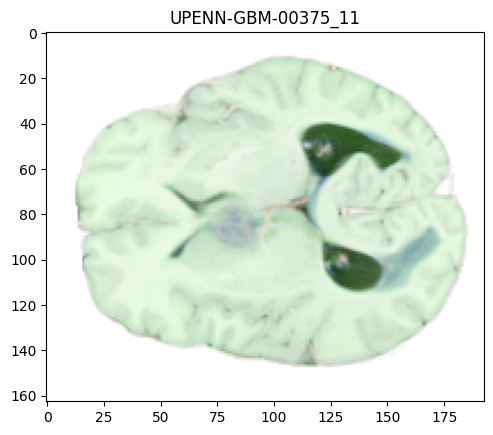

In [ ]:
# make a test plot just to ensure things are what we expect.
# plt.imshow(X[0, :, :, X[0].shape[-2] // 2])
# plt.title(patients[0]);

In [ ]:
# X[0, 3:, 1:, 2:].shape

(160, 192, 144, 4)

In [ ]:
# get random indices for train/validation
# np.random.seed(1)
# shuff_idx = np.random.permutation(np.arange(X.shape[0]))

In [ ]:
# shuff_idx

array([ 99,  93,  54, 103,  98,  75,  89,  53,  44,  59,   5,  16,  91,
        14,  58,  33,  73,  29,  66,  35, 117,  84,  31, 128, 109,  19,
        51,  48, 120, 141, 125, 132,  42, 138,  28,  40, 105, 118,  17,
       111,  78,  69,  74,  18,   4,  45,  56,  39,  36, 114, 136, 104,
       123,  83, 122, 119,  92,  11, 145,  85,  12,   2,  95, 110, 135,
         6, 124, 107,  65,  55,  77, 100,  46,  62, 113,  90,  97, 131,
        10,  34,  32, 121,  38, 108, 146,  27,  23,  67,   9, 127,  94,
       102, 130,  87, 143, 116,  64,  15,  82,  41,  80,  52,  26,  76,
        43,  24, 142, 112, 126,  49,  21,  70,   3, 139,  30, 144, 106,
        47, 115,  13,  88,   8,  81,  60,   0,   1,  57,  22,  61,  63,
         7,  86,  96,  68,  50, 101,  20,  25, 134,  71, 129,  79, 133,
       137,  72, 140,  37])

In [ ]:
# # get a subset of images to work with
# # clip limits of x, y, c to be [160, 192, 144]
# # NOTE: CANNOT CONVERT THE ENTIRE 147 3D VOLUMES TO FLOAT, OR ELSE WILL RUN OUT OF MEMORY
# X_train = X[shuff_idx[:36], 3:, 1:, 2:]
# X_valid = X[shuff_idx[-12:], 3:, 1:, 2:]
# # scale the values to range between 0 and 1
# X_train_norm = X_train.astype('float') / 255.
# X_valid_norm = X_valid.astype("float") / 255.

# assert X_train_norm.shape[1:] == X_valid_norm.shape[1:]
# print(X_train_norm.shape)
# print(X_valid_norm.shape)

(36, 160, 192, 144, 4)
(12, 160, 192, 144, 4)


In [ ]:
# # design a basic convolutional autoencoder

# conv_encoder = tf.keras.models.Sequential([
#     layers.Conv3D(16, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal", input_shape=[160, 192, 144, 4]),
#     layers.MaxPooling3D(pool_size=2),
#     layers.Conv3D(32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
#     layers.MaxPooling3D(pool_size=2),
#     layers.Conv3D(64, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
#     layers.MaxPooling3D(pool_size=2),
#     layers.Conv3D(128, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
#     layers.MaxPooling3D(pool_size=2),
# ])

# conv_decoder = tf.keras.models.Sequential([
#     layers.Conv3DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal", input_shape=[10, 12, 9, 128]),
#     layers.Conv3DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal"),
#     layers.Conv3DTranspose(16, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal"),
#     layers.Conv3DTranspose(4, kernel_size=3, strides=2, padding="same", activation="sigmoid", kernel_initializer="he_normal"),
#     layers.Reshape([160, 192, 144, 4]) 
# ])

# conv_ae = tf.keras.models.Sequential([conv_encoder, conv_decoder])

In [ ]:
# # compile the model, use mean squared error for loss function as pixels are scaled between 0 and 1
# conv_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
# # show the AE summary
# conv_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10, 12, 9, 128)    292272    
                                                                 
 sequential_1 (Sequential)   (None, 160, 192, 144, 4)  292148    
                                                                 
Total params: 584,420
Trainable params: 584,420
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # create an early stopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.0001,
#     patience=10,
# )

In [ ]:
# # fit the model
# conv_ae.fit(
#     X_train_norm, X_train_norm, batch_size=2, epochs=100,
#     validation_data=[X_valid_norm, X_valid_norm],
#     callbacks=[early_stopping]
# )

Epoch 1/100
18/18 [==============================] - 32s 780ms/step - loss: 0.1548 - val_loss: 0.0911
Epoch 2/100
18/18 [==============================] - 9s 504ms/step - loss: 0.0608 - val_loss: 0.0438
Epoch 3/100
18/18 [==============================] - 9s 499ms/step - loss: 0.0391 - val_loss: 0.0355
Epoch 4/100
18/18 [==============================] - 9s 499ms/step - loss: 0.0340 - val_loss: 0.0292
Epoch 5/100
18/18 [==============================] - 9s 506ms/step - loss: 0.0232 - val_loss: 0.0170
Epoch 6/100
18/18 [==============================] - 9s 501ms/step - loss: 0.0142 - val_loss: 0.0113
Epoch 7/100
18/18 [==============================] - 9s 508ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 8/100
18/18 [==============================] - 9s 512ms/step - loss: 0.0104 - val_loss: 0.0105
Epoch 9/100
18/18 [==============================] - 9s 504ms/step - loss: 0.0101 - val_loss: 0.0108
Epoch 10/100
18/18 [==============================] - 9s 520ms/step - loss: 0.0101 - val_l

In [ ]:
# # save the model
# conv_ae.save("baseline2_conv_autoencoder.h5")

### Reload the model and do some latent space analysis

In [ ]:
# aenc = tf.keras.models.load_model("baseline2_conv_autoencoder.h5")
# aenc.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10, 12, 9, 128)    292272    
                                                                 
 sequential_1 (Sequential)   (None, 160, 192, 144, 4)  292148    
                                                                 
Total params: 584,420
Trainable params: 584,420
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # extract the encoder
# encoder = aenc.layers[0]
# # pass a single input through the encoder to get the latent space representation
# latent_rep = encoder.predict(X_valid_norm[:1, :, :, :])

1/1 [==============================] - 2s 2s/step


In [ ]:
# latent_rep.shape

(1, 10, 12, 9, 128)

In [ ]:
# # upscale the latent space so that it has same spatial dims as inputs
# y = layers.UpSampling3D(size=16)(latent_rep)
# print(y.shape)

(1, 160, 192, 144, 128)


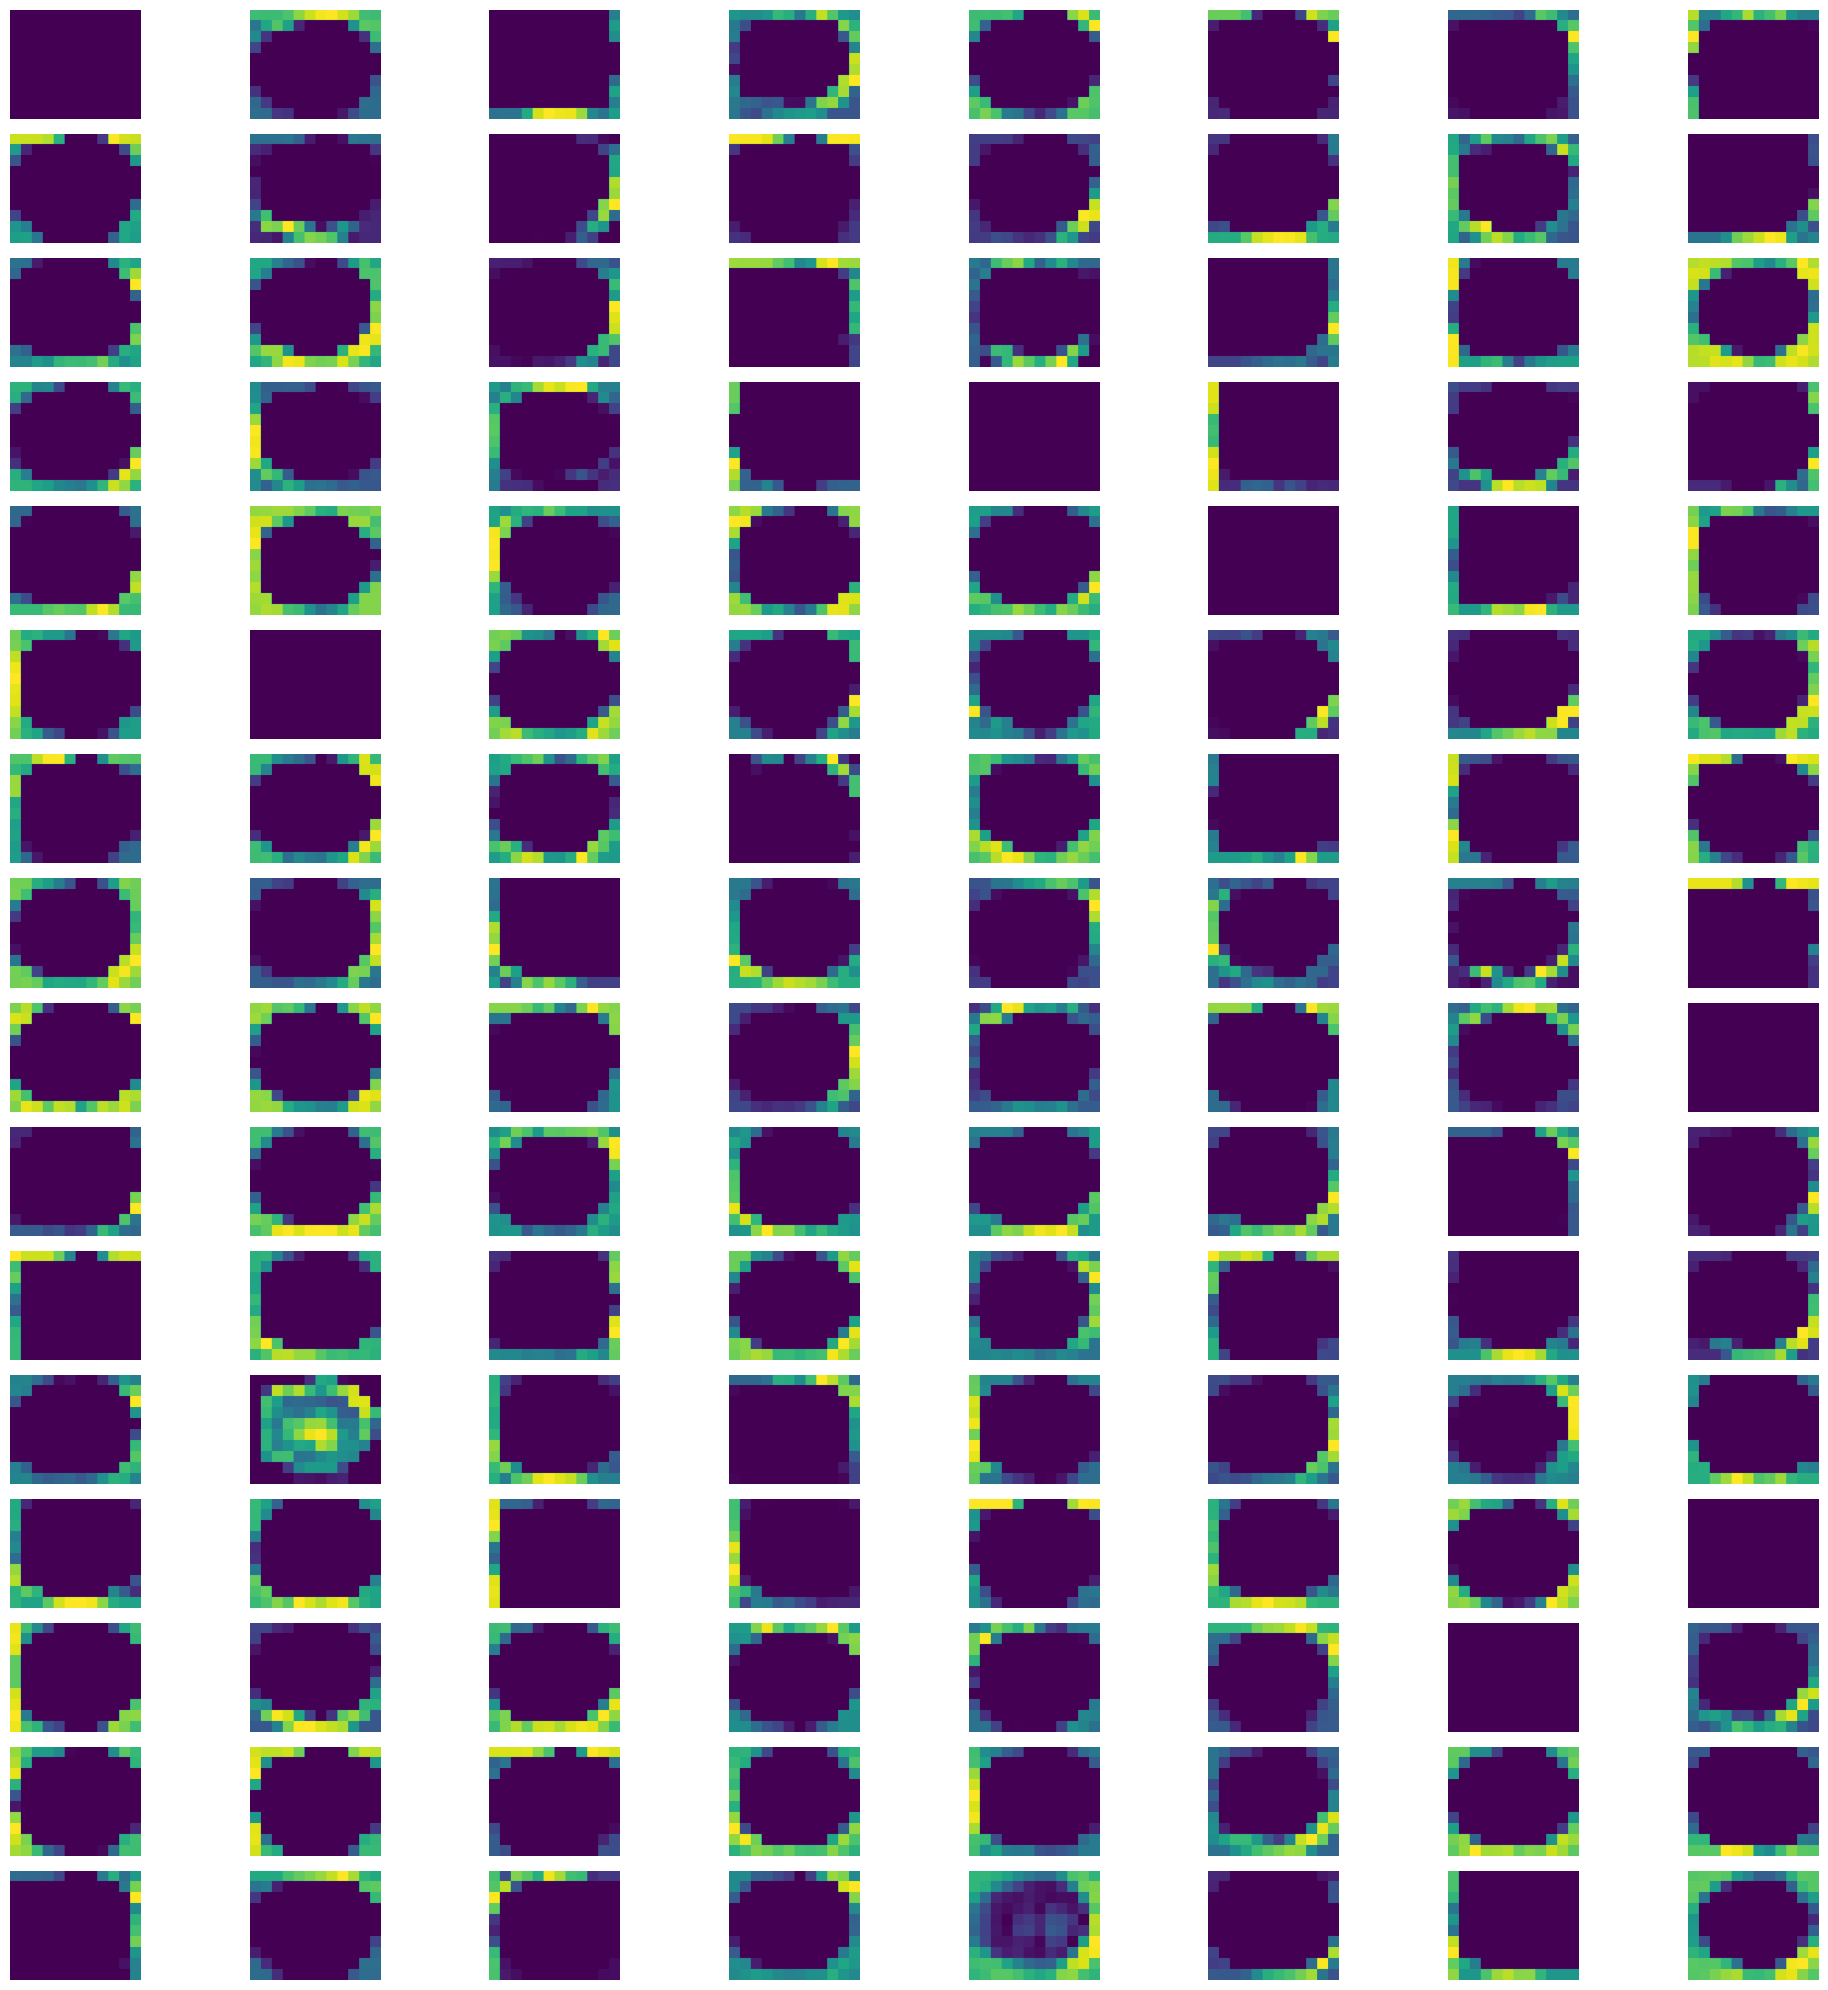

In [ ]:
# fig, axs = plt.subplots(nrows=16, ncols=8, figsize=(20, 20))
# for row in range(16):
#   for col in range(8):
#     axs[row, col].imshow(y[0, :, :, 144 // 2, row + col + (row * 7)])
#     axs[row, col].set_axis_off()
# plt.tight_layout()

One filter is learning the actual brain, but most seem to be learning the zero-data areas around the brain.

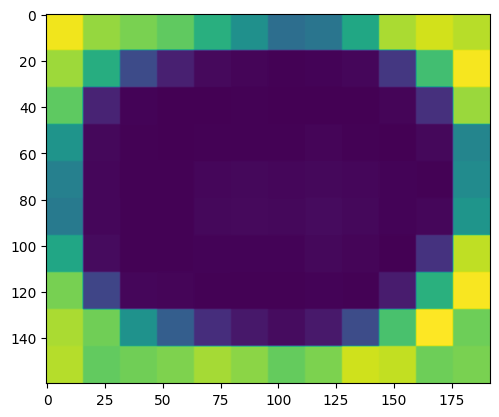

In [ ]:
# plt.imshow(np.sum(y, axis=-1)[0, :, :, 144 // 2]);

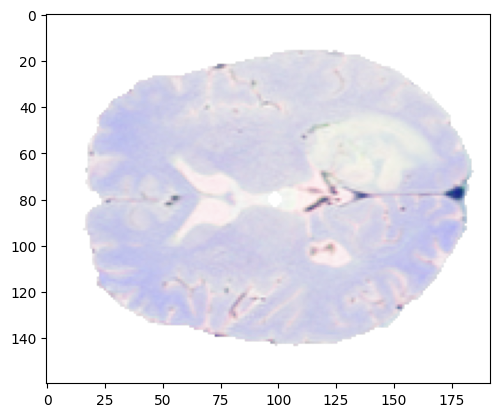

In [ ]:
# plt.imshow(X_valid_norm[0, :, :, 144 // 2, :]);

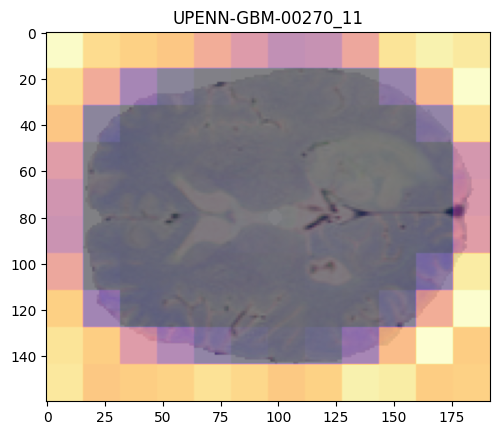

In [ ]:
# plt.imshow(X_valid_norm[0, :, :, 144 // 2, :])
# plt.imshow(np.sum(y, axis=-1)[0, :, :, 144 // 2], cmap="inferno", alpha=0.5)
# plt.title(patients[shuff_idx[-12]]);

1/1 [==============================] - 0s 93ms/step
(1, 160, 192, 144, 4)


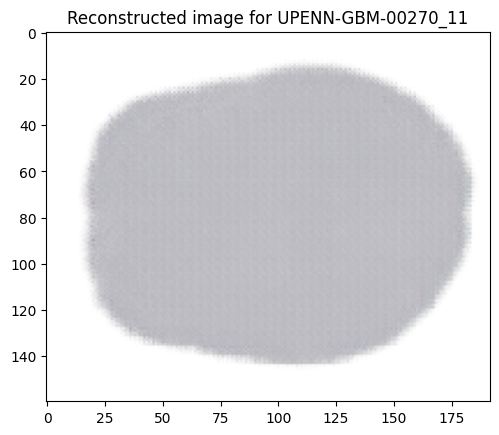

In [ ]:
# # look at the reconstructed image
# pred = aenc.predict(X_valid_norm[:1, :, :, :, :])
# pred = ((pred - pred.min()) * (1 / (pred.max() - pred.min()) * 255)).astype('uint8')
# print(pred.shape)
# plt.imshow(pred[0, :, :, pred.shape[3] // 2, :])
# plt.title(f"Reconstructed image for {patients[shuff_idx[-12]]}");

We get a reconstructed image that has the right shape, but mostly looks like noise.

## PyTorch

In [5]:
# Create a data list
create_ae_data_list(data_dir=IMG_REDUCED_DIR)

Number of unique samples: 147


In [6]:
# create a custom data set for use with PyTorch DataLoader
custom_ae_mri_data = AutoencoderMRIDataset(
    data_dir=IMG_REDUCED_DIR, 
    data_list_fn=os.path.join(IMG_REDUCED_DIR, "data_list.txt")
)

In [7]:
# set up data loader
batch_size = 2
dataloader = DataLoader(custom_ae_mri_data, batch_size=batch_size, shuffle=True)